In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import pickle
import keras
import tensorflow as tf
import warnings
from matplotlib import pyplot as plt
from IPython.display import clear_output
from keras import backend as K

from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten, LSTM, Embedding, Activation, Add, Bidirectional
from keras.layers import Conv2D, MaxPooling1D, AveragePooling1D, MaxPooling2D, TimeDistributed, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ReLU, ELU
from keras.regularizers import l2 # L2-regularisation
from keras.models import Model
from keras import optimizers
from keras.layers.advanced_activations import LeakyReLU

warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
def load_data(data_name):
    pkl_file = open(data_name + '.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

print('Loading data...')
folder = '../input/aminodataset/'

train = load_data(folder + 'train')
train_label = load_data(folder + 'train_label')
test = np.array(load_data(folder + 'test'))
test_label = load_data(folder + 'test_label')
valid = np.array(load_data(folder + 'valid'))
valid_label = load_data(folder + 'valid_label')
print('Data are loaded')

Loading data...
Data are loaded


In [ ]:
train.shape, np.shape(train_label)

In [ ]:
# train = train.reshape(train.shape[0], train.shape[1], train.shape[2])
# test = test.reshape(test.shape[0], test.shape[1], test.shape[2])
# valid = valid.reshape(valid.shape[0], valid.shape[1], valid.shape[2])

In [ ]:
train.shape, np.shape(train_label)

In [3]:
def relu_bn(inputs):
    relu = (ELU(alpha=0.1))(inputs)
    norm = (BatchNormalization())(relu)
    
    return norm


def residual_block_identity(x, l2_lambda):
        
    y = (Conv2D(filters = 16, 
                kernel_size = (5, 5), 
                activation='linear', 
                W_regularizer=l2(l2_lambda), 
                padding='same'))(x)
    
    y = (LeakyReLU(alpha=0.3))(y)
    
    y = (Conv2D(filters = 32, 
                kernel_size = (5, 5), 
                activation='linear', 
                W_regularizer=l2(l2_lambda), 
                padding='same'))(y)
    
    y = (LeakyReLU(alpha=0.3))(y)
    
    out = (Add())([x, y])
    out = (MaxPooling2D(pool_size = (2, 2), padding = 'same'))(out)
        
    out = (Dropout(0.5))(y)
    
    return out


def residual_block_convolutional(x, l2_lambda):
    
#     f1, f2, f3 = filters
        
    y = (Conv2D(filters = 16, 
               kernel_size = (1, 1),
               strides = (2, 2),
               activation = 'linear'))(x)
    
    y = (LeakyReLU(alpha=0.3))(y)
    
    y = (Conv2D(filters = 32, 
               kernel_size = (5, 5),
               padding = "same", 
               activation ='linear'))(y)

    y = (LeakyReLU(alpha=0.3))(y)
    
    x = (Conv2D(filters = 32, 
               kernel_size = (1, 1),
               strides = (2, 2),
               padding = "same", 
               activation ='linear'))(x)
    
    y = (LeakyReLU(alpha=0.3))(y)
        
    out = (Add())([x, y])
    out = (MaxPooling2D(pool_size = (2, 2), padding = 'same'))(out)
    out = (Dropout(0.5))(out)
    
    return out

In [4]:
def resnet(input_shape, out_shape, mm):
    
    l2_lambda = 0.0001
    num_blocks_list = [2]
    
    inputs = Input(input_shape)
        
    for i in range(len(num_blocks_list)):
        
        num_blocks = num_blocks_list[i]
        
        if i == 0:
            t = residual_block_convolutional(inputs, l2_lambda = l2_lambda)
        else:
            t = residual_block_convolutional(inputs, l2_lambda = l2_lambda)
        
        for j in range(num_blocks):
            t = residual_block_identity(t, l2_lambda = l2_lambda)
        
    t = (Conv2D(kernel_size = (5, 5),
           strides = (1, 1),
           filters = 1,
           padding = "same"))(t)
    
    t = (Reshape((t.shape[1], t.shape[2])))(t)
    
#     layer = (Flatten())(t)
    
    layer = (Bidirectional(LSTM(16, return_sequences=True)))(t)
    layer = (Dropout(0.4))(layer)
    
    layer = (Bidirectional(LSTM(32, return_sequences=True)))(layer)
    layer = (Dropout(0.4))(layer)
    
    layer = (Bidirectional(LSTM(64, return_sequences=True)))(t)
    layer = (Dropout(0.4))(layer)
    
    layer = (Bidirectional(LSTM(128, return_sequences=True)))(t)
    layer = (Dropout(0.4))(layer)
    
    layer = (Bidirectional(LSTM(256, return_sequences=True)))(t)
    layer = (Dropout(0.4))(layer)
    
    layer = (Bidirectional(LSTM(512)))(layer)
    layer = (Dropout(0.4))(layer)
    
#     layer = (Dense((mm), activation='linear', W_regularizer=l2(l2_lambda)))(layer)
#     layer = (LeakyReLU(alpha=0.1))(layer)
#     layer = (Dropout(0.5))(layer)
    finish = []
    
#     output = Dense(out_shape, activation='softmax', name='main_output'(layer4)

    for i in range(int((mm ** 2 - mm) / 2)):
        output = Dense(out_shape, activation='softmax', name='main_output'+str(i))(layer)
        finish.append(output)
        
    model = Model(inputs = [inputs], outputs = finish)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = keras.optimizers.Adam(lr=0.001))

    return model

In [5]:
batch_size = 16
epochs = 40
mm = 40

model = resnet((train.shape[1], train.shape[2], 1), 2, mm)

print('Start training...')
history = model.fit(train, list(train_label), batch_size = batch_size, epochs = epochs, verbose = 0,
                          validation_data=(valid, list(valid_label)))

Start training...


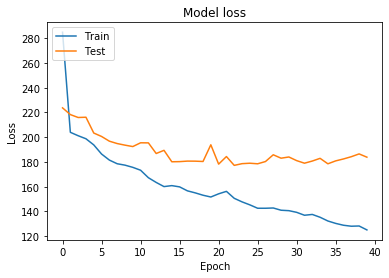

In [6]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('resnet')

## New cnn + lstm model

In [7]:
def cnnlstm(input_shape, output_shape, mm):
    
    l2_lambda = 0.0001
    
    inputs = (Input(input_shape))
    
    layer = (TimeDistributed(Conv2D(filters = 16, 
                                   kernel_size = (5, 5)))(inputs))
    
    layer = (TimeDistributed(MaxPooling2D(pool_size=(2, 2),padding='same'))(layer))
    layer = (TimeDistributed(Flatten())(layer))
    
    layer = (LSTM(16, return_sequences=True))(layer)
    layer = (Dropout(0.5))(layer)
    
    layer = (LSTM(32, return_sequences=True))(layer)
    layer = (Dropout(0.5))(layer)
    
    layer = (LSTM(64))(layer)
    layer = (Dropout(0.5))(layer)

    finish = []
#     output = (Dense(2, activation = 'softmax', name = 'main_output'))(output)
    for i in range(int((mm ** 2 - mm ) / 2)):
        output = (Dense(2, activation = 'softmax', name = 'main_output' + str(i)))(layer)
        finish.append(output)

    model = Model(inputs = [inputs], outputs = finish)
    
    model.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy'
    )
    
    return model

In [ ]:
print('Start training...')

model = cnnlstm((train.shape[1], train.shape[2], 1), mm, 2)

train_dropout = model.fit(train, list(train_label), batch_size = batch_size, epochs = epochs, verbose = 1,
                          validation_data = (np.array(valid), list(valid_label)))

In [8]:
predicted = model.predict(test)

print(np.shape(predicted))
print(np.shape(test_label))

output = open('predicted_res' + '.pkl', 'wb')
pickle.dump(predicted, output)
output.close()

output = open('test_res' + '.pkl', 'wb')
pickle.dump(test_label, output)
output.close()

(780, 73, 2)
(780, 73, 2)


In [9]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import operator
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


def score(test_label, predicted, metric):
    
    predicted = np.array(predicted).reshape(780 * 73, 2)
    test_label = np.array(test_label).reshape(780 * 73, 2)
    
    id_score = {}
    pred = []
    test = []
    
    L = []
    L_2 = []
    L_5 = []
    L_10 = []
    
    for i in range(len(predicted)):
        id_score[i] = predicted[i][1]
        
    for key, value in reversed(sorted(id_score.items(), key=operator.itemgetter(1))):
        pred.append(np.argmax([1 - value, value]))
        test.append(np.argmax(test_label[key]))
        
    if metric == 'recall':
        
        L.append(recall_score(test, pred))
        L_2.append(recall_score(test[:len(test) // 2], pred[:len(pred) // 2]))
        L_5.append(recall_score(test[:len(test) // 5], pred[:len(pred) // 5]))
        L_10.append(recall_score(test[:len(test) // 10], pred[:len(pred) // 10]))
        
    elif metric == 'f1':
        
        L.append(f1_score(test, pred))
        L_2.append(f1_score(test[:len(test) // 2], pred[:len(pred) // 2]))
        L_5.append(f1_score(test[:len(test) // 5], pred[:len(pred) // 5]))
        L_10.append(f1_score(test[:len(test) // 10], pred[:len(pred) // 10]))
        
    elif metric == 'precision':
        
        L.append(precision_score(test, pred))
        L_2.append(precision_score(test[:len(test) // 2], pred[:len(pred) // 2]))
        L_5.append(precision_score(test[:len(test) // 5], pred[:len(pred) // 5]))
        L_10.append(precision_score(test[:len(test) // 10], pred[:len(pred) // 10]))
        
    else:
        
        raise ValueError('No metric was found')
            
    return L, L_2, L_5, L_10

In [10]:
def print_results(test_label, proba):
    
    # f1 score
    
    L, L_2, L_5, L_10 = score(test_label, proba, 'f1')
    print('F1 score:')
    print('L:', L)
    print('L_2:', L_2)
    print('L_5:', L_5)
    print('L_10:', L_10)
    
    # precision score
    
    L, L_2, L_5, L_10 = score(test_label, proba, 'precision')
    print('Precision score:')
    print('L:', L)
    print('L_2:', L_2)
    print('L_5:', L_5)
    print('L_10:', L_10)
    
    
    # recall score
    
    L, L_2, L_5, L_10 = score(test_label, proba, 'recall')
    print('Recall score:')
    print('L:', L)
    print('L_2:', L_2)
    print('L_5:', L_5)
    print('L_10:', L_10)

In [11]:
print_results(test_label, predicted)

F1 score:
L: [0.774625171734066]
L_2: [0.7854633555420958]
L_5: [0.8642452515828056]
L_10: [0.9806659505907627]
Precision score:
L: [0.8745616401402752]
L_2: [0.8745616401402752]
L_5: [0.8745616401402752]
L_10: [0.9620653319283456]
Recall score:
L: [0.6951860190843787]
L_2: [0.7128408091468778]
L_5: [0.8541694111447767]
L_10: [1.0]
